# Recurrent Neural Networks

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
import tensorflow as tf

/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Basic RNNs

### Manual RNN

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


### Using `static_rnn()`

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542541 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.99976057, -0.0667929 , -0.9999803 ,  0.99982214],
       [-0.6524943 , -0.51520866, -0.37968948, -0.5922594 , -0.08968379],
       [ 0.99862397, -0.99715203, -0.03308626, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307606 ,  0.79671973]],
      dtype=float32)

In [13]:
from tensorflow_graph_in_jupyter import show_graph

In [14]:
show_graph(tf.get_default_graph())

### Packing sequences

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [19]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]]


In [20]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]
 [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]
 [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]


### Using `dynamic_rnn()`

In [21]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [24]:
init = tf.global_variables_initializer()

In [25]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [26]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


In [27]:
show_graph(tf.get_default_graph())

### Setting the sequence lengths

In [28]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [29]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [30]:
init = tf.global_variables_initializer()

In [31]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [32]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states],
        feed_dict={X: X_batch, seq_length: seq_length_batch}
    )

In [33]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.956726    0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [34]:
print(states_val)

[[-1.          0.956726    0.99831694  0.99970174  0.96518576]
 [-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]
 [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]


### Training a sequence classifier

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

In [35]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [36]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [37]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.93333334 Test accuracy: 0.9311
1 Train accuracy: 0.96666664 Test accuracy: 0.9522
2 Train accuracy: 0.97333336 Test accuracy: 0.9586
3 Train accuracy: 0.96666664 Test accuracy: 0.9607
4 Train accuracy: 0.97333336 Test accuracy: 0.9673
5 Train accuracy: 0.98 Test accuracy: 0.9669
6 Train accuracy: 0.97333336 Test accuracy: 0.9693
7 Train accuracy: 0.96666664 Test accuracy: 0.968
8 Train accuracy: 0.9533333 Test accuracy: 0.9723
9 Train accuracy: 0.97333336 Test accuracy: 0.9683
10 Train accuracy: 0.9866667 Test accuracy: 0.9734
11 Train accuracy: 0.96666664 Test accuracy: 0.969
12 Train accuracy: 0.9866667 Test accuracy: 0.9726
13 Train accuracy: 0.9866667 Test accuracy: 0.9774
14 Train accuracy: 0.98 Test accuracy: 0.9705
15 Train accuracy: 0.9866667 Test accuracy: 0.976
16 Train accuracy: 0.9866667 Test accuracy: 0.9739
17 Train accuracy: 0.9866667 Test accuracy: 0.9709
18 Train accuracy: 0.98 Test accuracy: 0.9736
19 Train accuracy: 0.9866667 Test accuracy: 0.9775

## Multi-layer RNN

In [38]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [39]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [40]:
states_concat = tf.concat(axis=1, values=states)

logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [41]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.9266667 Test accuracy: 0.9456
1 Train accuracy: 0.9866667 Test accuracy: 0.9647
2 Train accuracy: 0.94666666 Test accuracy: 0.9663
3 Train accuracy: 0.98 Test accuracy: 0.9757
4 Train accuracy: 0.98 Test accuracy: 0.9724
5 Train accuracy: 0.9866667 Test accuracy: 0.9785
6 Train accuracy: 0.9866667 Test accuracy: 0.9692
7 Train accuracy: 1.0 Test accuracy: 0.981
8 Train accuracy: 0.99333334 Test accuracy: 0.9788
9 Train accuracy: 0.99333334 Test accuracy: 0.9809


## Time series

In [42]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

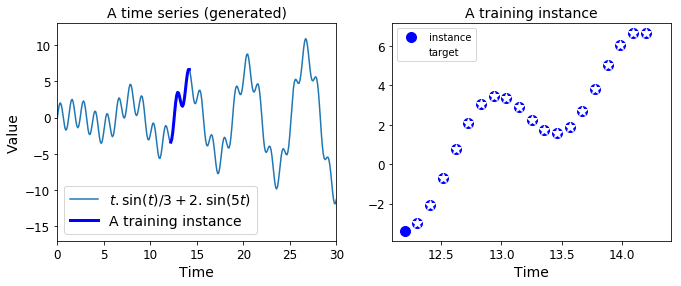

In [44]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show();

In [45]:
X_batch, y_batch = next_batch(1, n_steps)

In [46]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

### Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [47]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [48]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [49]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs
)

In [50]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [51]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [52]:
saver = tf.train.Saver()

In [53]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./tmp/my_time_series_model")

0 	MSE: 11.967254
100 	MSE: 0.525841
200 	MSE: 0.1495599
300 	MSE: 0.07279411
400 	MSE: 0.06158535
500 	MSE: 0.05938873
600 	MSE: 0.05470166
700 	MSE: 0.047849063
800 	MSE: 0.05107608
900 	MSE: 0.047209196
1000 	MSE: 0.047058314
1100 	MSE: 0.047831465
1200 	MSE: 0.04083041
1300 	MSE: 0.047086805
1400 	MSE: 0.041784383


In [54]:
with tf.Session() as sess:                          
    saver.restore(sess, "./tmp/my_time_series_model")   

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./tmp/my_time_series_model


In [55]:
y_pred

array([[[-3.407753 ],
        [-2.4575484],
        [-1.1029298],
        [ 0.7815629],
        [ 2.2002175],
        [ 3.126768 ],
        [ 3.4037762],
        [ 3.3489153],
        [ 2.8798013],
        [ 2.2659323],
        [ 1.6447463],
        [ 1.5210768],
        [ 1.8972012],
        [ 2.7159088],
        [ 3.8894904],
        [ 5.140914 ],
        [ 6.142068 ],
        [ 6.666671 ],
        [ 6.6410103],
        [ 6.0725527]]], dtype=float32)

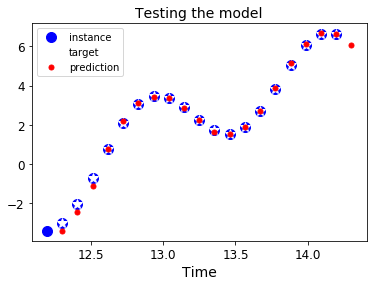

In [56]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show();

### Without using an `OutputProjectionWrapper`

In [57]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [58]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [59]:
n_outputs = 1
learning_rate = 0.001

In [60]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [61]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [62]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./tmp/my_time_series_model")

0 	MSE: 13.907029
100 	MSE: 0.5056698
200 	MSE: 0.19735886
300 	MSE: 0.101214476
400 	MSE: 0.06850145
500 	MSE: 0.06291986
600 	MSE: 0.055129297
700 	MSE: 0.049436502
800 	MSE: 0.050434686
900 	MSE: 0.0482007
1000 	MSE: 0.04809868
1100 	MSE: 0.04982501
1200 	MSE: 0.041912545
1300 	MSE: 0.049292978
1400 	MSE: 0.043140374


In [63]:
y_pred

array([[[-3.4332483],
        [-2.4594698],
        [-1.1081185],
        [ 0.6882153],
        [ 2.1105688],
        [ 3.0585155],
        [ 3.5144088],
        [ 3.3531117],
        [ 2.808016 ],
        [ 2.1606152],
        [ 1.662645 ],
        [ 1.5578941],
        [ 1.9173537],
        [ 2.7210245],
        [ 3.8667865],
        [ 5.100083 ],
        [ 6.099999 ],
        [ 6.6480975],
        [ 6.6147423],
        [ 6.022089 ]]], dtype=float32)

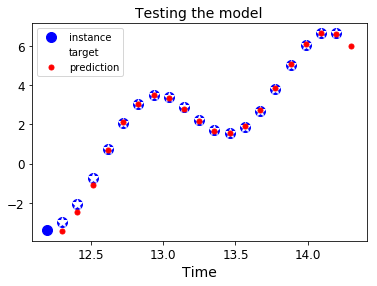

In [64]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show();

### Generating a creative new sequence

In [65]:
with tf.Session() as sess:                        
    saver.restore(sess, "./tmp/my_time_series_model")

    sequence = [0.] * n_steps
    
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./tmp/my_time_series_model


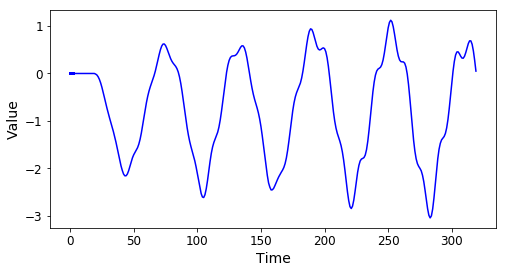

In [66]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show();

INFO:tensorflow:Restoring parameters from ./tmp/my_time_series_model


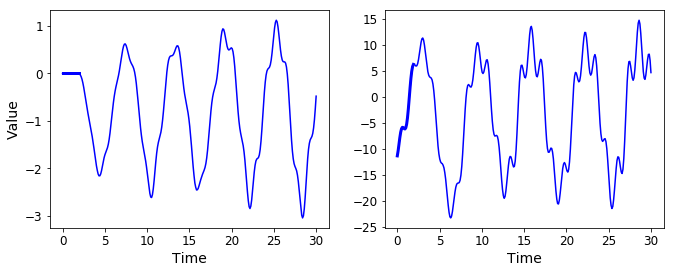

In [67]:
with tf.Session() as sess:
    saver.restore(sess, "./tmp/my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show();

## Deep RNN

### MultiRNNCell

In [68]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [69]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [70]:
init = tf.global_variables_initializer()

In [71]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [72]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [74]:
outputs_val.shape

(2, 5, 100)

### Distributing a Deep RNN Across Multiple GPUs

Do **NOT** do this:

In [ ]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

Instead, you need a `DeviceCellWrapper`:

In [75]:
class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
    def __init__(self, device, cell):
        self._cell = cell
        self._device = device
        
    @property
    def state_size(self):
        return self._cell.state_size
    
    @property
    def output_size(self):
        return self._cell.output_size
    
    def __call__(self, inputs, state, scope=None):
        with tf.device(self._device):
            return self._cell(inputs, state, scope)

In [76]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [77]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev, tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)) for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Alternatively, since TensorFlow 1.1, you can use the `tf.contrib.rnn.DeviceWrapper` class (alias `tf.nn.rnn_cell.DeviceWrapper` since TF 1.2).

In [78]:
init = tf.global_variables_initializer()

In [79]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-3.29020061e-02  1.17019236e-01 -4.58992608e-02 ...  3.84477153e-02
   -5.24900258e-02  5.80436960e-02]
  [ 3.54288332e-02 -7.42610693e-02 -6.42375052e-02 ... -2.45757148e-01
   -1.77626804e-01 -3.26535292e-03]
  [ 2.59726584e-01  1.44605249e-01  3.29312116e-01 ...  3.38821977e-01
    5.98853417e-02 -8.31450596e-02]
  ...
  [ 1.18043743e-01 -2.41663873e-01 -8.27798247e-01 ... -1.85782462e-01
    1.89682379e-01 -1.35261893e-01]
  [ 2.87830859e-01  3.92953992e-01 -3.15236300e-01 ... -7.85605535e-02
    4.32724983e-01 -6.61824420e-02]
  [ 7.49779761e-01  6.11052871e-01 -3.01685542e-01 ...  1.95649698e-01
   -1.62457466e-01 -5.23968339e-02]]

 [[-6.68027624e-02  7.35576972e-02 -2.90275402e-02 ... -7.79968277e-02
   -3.65773253e-02 -4.66752201e-02]
  [ 1.71546549e-01  4.28418722e-03  2.18812120e-03 ...  3.68538052e-02
   -8.13241452e-02  9.01001915e-02]
  [ 3.45635489e-02 -9.57525298e-02  1.59450233e-01 ...  1.63022086e-01
   -6.83046281e-02  1.07990295e-01]
  ...
  [ 1.96414590e-01 -2.1